![ibm cloud logo](./images/ibm-cloud.png)

# Case Study - Multiple testing

In [1]:
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/355136255', width=600,height=400)

### Learning objective

|                                                                     | 
|:--------------------------------------------------------------------|
| Explain methods for dealing with multiple testing                   |

## Synopsis

The management team at AAVAIL is preparing to deploy a large number of teams each tasked with integration into a different new market.  They claim to have a optimized the teams fairly with respect to skills and experience.  They are asking you to come up with a framework to evaluate the makeup of their teams.  They have not finished hiring and creating all of the teams so naturally before you even get the data you wanted to get a head start.

Getting a head start usually involves finding a similar dataset and writing the code in a way that the new data, once obtained can be added with little effort.

When we perform a large number of statistical tests, some will have $p$-values less than the designated level of $\alpha$ (e.g. 0.05) purely by chance, even if all the null hypotheses are really true.  This is an inherent risk of using inferrential statistics.  Fortunately, there are several techniques to mitigate the risk.

We are going to look at the 2018 world cup data in this example.  

The case study is comprised of the following sections:

1. Data Cleaning
2. Data Visualization
3. NHT
4. Adjust NHT results for multiple comparisons

Data science work that focuses on creating a predictive model is perhaps the hallmark of the field today, but there are still many use cases where [inferential statistics](https://en.wikipedia.org/wiki/Statistical_inference) are the best tool available. One issue with statistical inference is that there are situations where [performing multiple tests](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) is a  logical way to accomplish a task, but it comes at the expense of an increased rate of false positives or Type I errors.

In this case study you will apply techniques and knowledge from all of the units in Module 2.

## Running Notebook on IBM Watson

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [4]:
cos2file(project, '/data', 'worldcup-2018.csv')

## Getting started

**This unit is interactive**.  During this unit we encourage you to [open this file as a notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest).  Download the notebook from the following link then open it locally using a Jupyter server or use your IBM cloud account to login to Watson Studio.  Inside of Waston Studio cloud if you have not already ensure that this notebook is loaded as part of the *project* for this course. As a reminder fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***.  The data and notebook for this unit are available below.

* [m2-u7-case-study.ipynb](m2-u7-case-study.ipynb)
* [worldcup-2018.csv](./data/worldcup-2018.csv)

This unit is organized into the following sections:

1. Data Processing
2. Data Summary
3. Investigative Visualization
4. Hypothesis testing

#### Resources

* [Creating or uploading a notebook in IBM cloud](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/creating-notebooks.html)
* [Resources for multiple testing in Python](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html)

In [5]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## Import the Data

Before we jump into the data it can be useful to give a little background so that you can better understand the features.  Since the dawn of statistics practitioners have been trying to find advantages when it comes to games.  Much of this was motivated by gambling---here we will look at the results from this tournament in a different way.  We are going to ask the simple question

  >Was the tournament setup in a fair way?

Of course the findings from an investigation centering around this question could be used to strategically place bets, but lets assume that we are simply interested in whether or not the tournament organizers did an adequate job.  The reason for doing this is to prepare for the AAVAIL data that is coming.  This exercise is an important reminder that you do not have to wait until the day that data arrive to start your work. 

There are 32 teams, each representing a single country, that compete in groups or pools then the best teams from those groups compete in a single elimination tournament to see who will become world champions.  This is by far the world's most popular sport so one would hope that the governing organization FIFA did a good job composing the pools.  If for example there are 8 highly ranked teams then each of those teams should be in a different pool. 

In our data set we have more than just rank so we can dig in a little deeper than that, but first let's have a look at the data.

In [6]:
DATA_DIR = os.path.join("..","data")
df = pd.read_csv(os.path.join(DATA_DIR, 'worldcup-2018.csv'))
df.columns = [re.sub("\s+","_",col.lower()) for col in df.columns]
df.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,first_match_against,match_index,history_with_first_opponent_w-l,history_with_first_opponent_goals,second_match_against,match_index.1,history_with_second_opponent_w-l,history_with_second_opponent_goals,third_match_against,match_index.2,history_with_third_opponent_w-l,history_with_third_opponent_goals,unnamed:_19
0,Russia,A,10,0,0,1,65,Saudi Arabia,1,-1.0,-2.0,Egypt,17,NaN,NaN,Uruguay,33,0.0,0.0,NaN
1,Saudi Arabia,A,4,0,0,0,63,Russia,1,1.0,2.0,Uruguay,18,1.0,1.0,Egypt,34,-5.0,-5.0,NaN
2,Egypt,A,2,0,0,0,31,Uruguay,2,-1.0,-2.0,Russia,17,NaN,NaN,Saudi Arabia,34,5.0,5.0,NaN
3,Uruguay,A,12,2,2,5,21,Egypt,2,1.0,2.0,Saudi Arabia,18,-1.0,-1.0,Russia,33,0.0,0.0,NaN
4,Porugal,B,6,0,0,2,3,Spain,3,-12.0,-31.0,Morocco,19,-1.0,-2.0,Iran,35,2.0,5.0,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 20 columns):
team                                  32 non-null object
group                                 32 non-null object
previous_appearances                  32 non-null int64
previous_titles                       32 non-null int64
previous_finals                       32 non-null int64
previous_semifinals                   32 non-null int64
current_fifa_rank                     32 non-null int64
first_match_against                   32 non-null object
match_index                           32 non-null int64
history_with_first_opponent_w-l       20 non-null float64
history_with_first_opponent_goals     20 non-null float64
second_match_against                  32 non-null object
match_index.1                         32 non-null int64
history_with_second_opponent_w-l      22 non-null float64
history_with_second_opponent_goals    22 non-null float64
third_match_against                   32 non-

To limit the dataset for educational purposes we create a new data frame that consists of only the following columns: 

* team
* group
* previous_appearances
* previous_titles
* previous_finals
* previous_semifinals
* current_fifa_rank

## Data Processing

### QUESTION 1

Using the column names below create a new dataframe that uses only them.

In [8]:
columns = ['team', 'group','previous_appearances','previous_titles','previous_finals',
           'previous_semifinals','current_fifa_rank']

dataset = df[columns].copy()
dataset.head()

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank
0,Russia,A,10,0,0,1,65
1,Saudi Arabia,A,4,0,0,0,63
2,Egypt,A,2,0,0,0,31
3,Uruguay,A,12,2,2,5,21
4,Porugal,B,6,0,0,2,3


To help with this analysis we are going to engineer a feature that combines all of the data in the table.  This feature represents the past performance of a team.  Given the data we have it is the best proxy on hand for how good a team will perfom.  Feel free to change the multiplers, but let's just say that `past_performance` will be a linear combination of the related features we have.

Let $X_{1}$,...,$X_{4}$ be `previous_titles`,`previous_finals`,`previous_semifinals`,`previous_appearances` and let the corresponding vector $\mathbf{\alpha}$ be the multipliers.  This will give us,

$$
\textrm{past_performance} = \alpha_{1} X_{1} + \alpha_{2} X_{2} + \alpha_{3} X_{3} + \alpha_{4} X_{4}
$$

Modify $\mathbf{\alpha}$ if you wish.  Then add to your dataframe the new feature `past_performance`.

### QUESTION 2

create the engineered feature as a new column

In [9]:
alpha = np.array([16,8,4,1])

print(alpha.shape)

X = dataset[["previous_titles", "previous_finals", "previous_semifinals", "previous_appearances"]].values
print(X.shape)

dataset["past_performance"] = np.dot(X, alpha)
dataset.head()

(4,)
(32, 4)


,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
0,Russia,A,10,0,0,1,65,14
1,Saudi Arabia,A,4,0,0,0,63,4
2,Egypt,A,2,0,0,0,31,2
3,Uruguay,A,12,2,2,5,21,80
4,Porugal,B,6,0,0,2,3,14


## Data Summary

### QUESTION 3

Using your choice of tools create one or more **tabular summaries** of the data

I will start with getting more insights into the data set and understand the data structure. First, I want to see the total number of rows and columns as well as the different types of features.

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
team                    32 non-null object
group                   32 non-null object
previous_appearances    32 non-null int64
previous_titles         32 non-null int64
previous_finals         32 non-null int64
previous_semifinals     32 non-null int64
current_fifa_rank       32 non-null int64
past_performance        32 non-null int64
dtypes: int64(6), object(2)
memory usage: 2.1+ KB


The dataset has 32 rows and 8 columns. The features `team` and `group` are of type `object`, the rest is type `int62`.

Let's see some general statistics about the numerical features in the dataset.

In [11]:
dataset.describe()

,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,7.906250,0.500000,0.843750,1.781250,24.781250,29.781250
std,5.426098,1.191367,2.017814,3.128788,19.536128,51.021649
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,8.750000,4.000000
50%,5.500000,0.000000,0.000000,0.000000,19.500000,9.000000
75%,12.000000,0.000000,0.250000,2.000000,37.500000,23.000000
max,20.000000,5.000000,8.000000,13.000000,65.000000,200.000000


The dataset has different scales

Let's get the top five teams based on the past performance

In [12]:
dataset.sort_values("past_performance", ascending=False).head(5)

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
16,Brazil,E,20,5,7,11,2,200
20,Germany,F,18,4,8,13,1,198
12,Argentina,D,16,2,5,5,4,108
3,Uruguay,A,12,2,2,5,21,80
8,France,C,14,1,2,5,9,66


It would be interesting to see the average past performance in each group.

In [13]:
pd.pivot_table(dataset, index = ['group'], values = 'past_performance', aggfunc="mean")

,past_performance
group,
A,25.00
B,17.00
C,19.50
D,30.25
E,58.25
F,65.25
G,16.50
H,6.50


In [14]:
pd.pivot_table(dataset, index = ['group'], values = 'past_performance', aggfunc="std")

,past_performance
group,
A,37.040518
B,19.899749
C,31.000000
D,51.938265
E,94.700845
F,89.055694
G,20.808652
H,5.972158


Group F has the highest score based on the past performance and Group E the highest standard deviation.

In [15]:
dataset[dataset.group=="F"]

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
20,Germany,F,18,4,8,13,1,198
21,Mexico,F,15,0,0,0,16,15
22,Sweden,F,11,0,1,4,18,35
23,Korea,F,9,0,0,1,59,13


In [16]:
dataset[dataset.group=="E"]

,team,group,previous_appearances,previous_titles,previous_finals,previous_semifinals,current_fifa_rank,past_performance
16,Brazil,E,20,5,7,11,2,200
17,Switzerland,E,10,0,0,0,8,10
18,Costarica,E,4,0,0,0,26,4
19,Serbia,E,11,0,0,2,37,19


### QUESTION 4

Check for missing data. Write code to identify if there is any missing data.

In [17]:
#missing data
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
past_performance,0,0.0
current_fifa_rank,0,0.0
previous_semifinals,0,0.0
previous_finals,0,0.0
previous_titles,0,0.0
previous_appearances,0,0.0
group,0,0.0
team,0,0.0


There are no missing values in the dataset

## Investigative Visualization

### QUESTION 5

Come up with one or more plots that investigate the central question... Are the groups comprised in a fair way?

Plot the average past performance per group

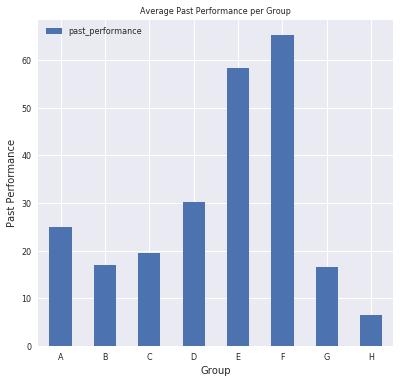

In [18]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table = pd.pivot_table(dataset, index = ['group'], values = 'past_performance', aggfunc="mean")
table.plot(kind='bar', ax=ax1, rot=0)
ax1.set_xlabel("Group")
ax1.set_ylabel("Past Performance")
ax1.title.set_text("Average Past Performance per Group")

Plot the past performance std within each group

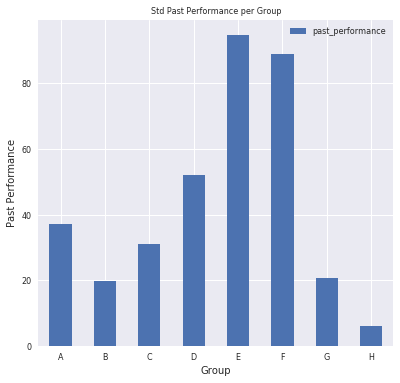

In [19]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table = pd.pivot_table(dataset, index = ['group'], values = 'past_performance', aggfunc="std")
table.plot(kind='bar', ax=ax1, rot=0)
ax1.set_xlabel("Group")
ax1.set_ylabel("Past Performance")
ax1.title.set_text("Std Past Performance per Group")

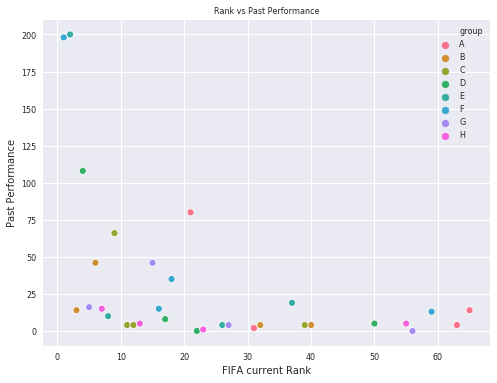

In [20]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
sns.scatterplot(x="current_fifa_rank", y="past_performance", hue="group", data=dataset, ax=ax1)

ax1.set_xlabel("FIFA current Rank")
ax1.set_ylabel("Past Performance")
ax1.title.set_text("Rank vs Past Performance")

## Hypothesis Testing

There are a number of ways to use hypothesis testing in this situation.  There are certainly reasonable hypotheses tests and other methods like simulation approaches, that we have not discussed, but they would be appropriate here.  If you choose to explore some of the methods that are outside the scope of this course then we encourage you to first try the simple approach proposed here and compare the results to any further additional approaches you choose to use.

We could use an ANOVA approach here that would signify a difference between groups, but we would not know which and how many teams were different.  As we stated before there are a number of ways to approach the investigation, but lets use a simple approach.  We are going to setup our investigation to look at all pairwise comparisons to provide as much insight as possible.

Recall that there are $\frac{(N-1)(N)}{2}$ pairwise comparisons.

In [21]:
N = np.unique(df['group'].values).size
print("num comparisons: ",((N-1)*N) / 2.0)

num comparisons:  28.0


### QUESTION 5


1. Choose a hypothesis test
2. State the null and alternative hypothesis, and choose a cutoff value $\alpha$
3. Run the test for all pairwise comparisons between teams

YOUR ANSWER HERE

**Hypothesis Testing**

1. Pose the **question**: *Are the groups comprised in a fair way?*
2. Find the relevant **population**: *The population consists of the feature values for the teams in the groups*
3. Specify a **null hypothesis**: *There is no difference, on average, between the way groups are comprised*
4. Select the **test** and the **significance level**: We want to distinguish between the groups, that is the data fall into many categories and you want to establish whether there is a difference in outcomes based on those categories. **ANOVA** would be more appropriate here with **$\alpha= 0.05$**.


If the p-value is less than 0.05, we reject the null hypothesis 

In [22]:
import numpy as np
from scipy import stats

def calculate_pvalue(df, feature):
    
    n_groups = 8
    n_teams_in_group = 4

    values = df[feature].values.reshape(n_groups, n_teams_in_group)
    
    global_mean = values.mean()
    print("The global mean {} is: {}".format(feature, np.round(global_mean, decimals=2)))
    
    test_statistic, pvalue = stats.f_oneway(*values)
    print("ANOVA p-value {}".format(np.round(pvalue, decimals=4)))
    
    return pvalue

pvals = []
for feature in ["previous_appearances", "previous_titles", "previous_finals", "previous_semifinals", "current_fifa_rank", "past_performance"]:
    pvals.append(calculate_pvalue(dataset, feature))
    
pvals

The global mean previous_appearances is: 7.91
ANOVA p-value 0.3586
The global mean previous_titles is: 0.5
ANOVA p-value 0.8674
The global mean previous_finals is: 0.84
ANOVA p-value 0.7593
The global mean previous_semifinals is: 1.78
ANOVA p-value 0.6492
The global mean current_fifa_rank is: 24.78
ANOVA p-value 0.639
The global mean past_performance is: 29.78
ANOVA p-value 0.7362


[0.35861196706544474,
 0.8673719928408031,
 0.7593046691402086,
 0.6491930573823975,
 0.6390161653805875,
 0.736184537526492]

In this case, the p-value is higher than 0.05 and thus we accept the null hypothesis

Calculate p-value on different features

### QUESTION 6

For all of the $p$-values obtained apply the Bonferroni and at least one other correction for multiple hypothesis tests.  Then comment on the results.

In [23]:
import numpy as np
from statsmodels.stats.multitest import multipletests

_results = multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
rejected_bonferroni, adjusted_bonferroni = _results[0],_results[1]

_results = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
rejected_bh,adjusted_bh = _results[0],_results[1]

for p, pval in enumerate(pvals):
     print(round(pval, 4),round(adjusted_bonferroni[p],4), round(adjusted_bh[p], 4))

0.3586 1.0 0.8674
0.8674 1.0 0.8674
0.7593 1.0 0.8674
0.6492 1.0 0.8674
0.639 1.0 0.8674
0.7362 1.0 0.8674


In [24]:
from scipy.stats import binom

binom.cdf(2701, 108879, 0.025)

0.34647434249300585

We accept the Null Hypothesis and can argue that the groups are comprised in a fair way.

## Additional Approaches 

There is an [allpairtest function in statsmodels](http://www.statsmodels.org/devel/generated/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest) that could be used here to combine the work from QUESTION 5 and QUESTION 6.

Generalized Linear Models (GLMs) are an appropriate tool to use here if we wanted to include the results of the tournament (maybe a ratio of wins/losses weighted by the final position in the tournament).  `statsmodels` supports [R-style formulas to fit generalized linear models](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html). One additional variant of GLMs are hierarchical or multilevel models that provide even more insight into this types of dataset.  See the [tutorial on multilevel modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html).